In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
# from diffusers import StableDiffusionImg2ImgPipeline
import torchvision.transforms as T

# from utils import preprocess, recover_image

/workspace/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
to_pil = T.ToPILImage()

### First lets instantiate a stable diffusion model

In [3]:
import torch
from dataclasses import dataclass, field
from einops import rearrange
import os
from torch.utils.data import DataLoader


import tgs
from tgs.models.image_feature import ImageFeature
from tgs.utils.saving import SaverMixin
from tgs.utils.config import parse_structured
from tgs.utils.ops import points_projection
from tgs.utils.misc import load_module_weights
from tgs.utils.typing import *

class TGS(torch.nn.Module, SaverMixin):
    @dataclass
    class Config:
        weights: Optional[str] = None
        weights_ignore_modules: Optional[List[str]] = None

        camera_embedder_cls: str = ""
        camera_embedder: dict = field(default_factory=dict)

        image_feature: dict = field(default_factory=dict)

        image_tokenizer_cls: str = ""
        image_tokenizer: dict = field(default_factory=dict)

        tokenizer_cls: str = ""
        tokenizer: dict = field(default_factory=dict)

        backbone_cls: str = ""
        backbone: dict = field(default_factory=dict)

        post_processor_cls: str = ""
        post_processor: dict = field(default_factory=dict)

        renderer_cls: str = ""
        renderer: dict = field(default_factory=dict)

        pointcloud_generator_cls: str = ""
        pointcloud_generator: dict = field(default_factory=dict)

        pointcloud_encoder_cls: str = ""
        pointcloud_encoder: dict = field(default_factory=dict)
    
    cfg: Config

    def load_weights(self, weights: str, ignore_modules: Optional[List[str]] = None):
        state_dict = load_module_weights(
            weights, ignore_modules=ignore_modules, map_location="cpu"
        )
        self.load_state_dict(state_dict, strict=False)

    def __init__(self, cfg):
        super().__init__()
        self.cfg = parse_structured(self.Config, cfg)
        self._save_dir: Optional[str] = None

        self.image_tokenizer = tgs.find(self.cfg.image_tokenizer_cls)(
            self.cfg.image_tokenizer
        )

        assert self.cfg.camera_embedder_cls == 'tgs.models.networks.MLP'
        weights = self.cfg.camera_embedder.pop("weights") if "weights" in self.cfg.camera_embedder else None
        self.camera_embedder = tgs.find(self.cfg.camera_embedder_cls)(**self.cfg.camera_embedder)
        if weights:
            from tgs.utils.misc import load_module_weights
            weights_path, module_name = weights.split(":")
            state_dict = load_module_weights(
                weights_path, module_name=module_name, map_location="cpu"
            )
            self.camera_embedder.load_state_dict(state_dict)

        self.image_feature = ImageFeature(self.cfg.image_feature)

        self.tokenizer = tgs.find(self.cfg.tokenizer_cls)(self.cfg.tokenizer)

        self.backbone = tgs.find(self.cfg.backbone_cls)(self.cfg.backbone)

        self.post_processor = tgs.find(self.cfg.post_processor_cls)(
            self.cfg.post_processor
        )

        self.renderer = tgs.find(self.cfg.renderer_cls)(self.cfg.renderer)

        # pointcloud generator
        self.pointcloud_generator = tgs.find(self.cfg.pointcloud_generator_cls)(self.cfg.pointcloud_generator)

        self.point_encoder = tgs.find(self.cfg.pointcloud_encoder_cls)(self.cfg.pointcloud_encoder)

        # load checkpoint
        if self.cfg.weights is not None:
            self.load_weights(self.cfg.weights, self.cfg.weights_ignore_modules)
    
    def _forward(self, batch: Dict[str, Any]) -> Dict[str, Any]:
        # generate point cloud
        out = self.pointcloud_generator(batch)
        pointclouds = out["points"]

        batch_size, n_input_views = batch["rgb_cond"].shape[:2]

        # Camera modulation
        camera_extri = batch["c2w_cond"].view(*batch["c2w_cond"].shape[:-2], -1)
        camera_intri = batch["intrinsic_normed_cond"].view(*batch["intrinsic_normed_cond"].shape[:-2], -1)
        camera_feats = torch.cat([camera_intri, camera_extri], dim=-1)

        camera_feats = self.camera_embedder(camera_feats)

        input_image_tokens: Float[Tensor, "B Cit Nit"] = self.image_tokenizer(
            rearrange(batch["rgb_cond"], 'B Nv H W C -> B Nv C H W'),
            modulation_cond=camera_feats,
        )
        input_image_tokens = rearrange(input_image_tokens, 'B Nv C Nt -> B (Nv Nt) C', Nv=n_input_views)

        # get image features for projection
        image_features = self.image_feature(
            rgb = batch["rgb_cond"],
            mask = batch.get("mask_cond", None),
            feature = input_image_tokens
        )
        # print("image feature : ",image_features.shape) # 1,773,252,252
        # only support number of input view is one
        c2w_cond = batch["c2w_cond"].squeeze(1)
        intrinsic_cond = batch["intrinsic_cond"].squeeze(1)
        proj_feats = points_projection(pointclouds, c2w_cond, intrinsic_cond, image_features)
        # print(proj_feats.shape) torch.Size([1, 16384, 773])
        point_cond_embeddings = self.point_encoder(torch.cat([pointclouds, proj_feats], dim=-1))
        tokens: Float[Tensor, "B Ct Nt"] = self.tokenizer(batch_size, cond_embeddings=point_cond_embeddings)

        tokens = self.backbone(
            tokens,
            encoder_hidden_states=input_image_tokens,
            modulation_cond=None,
        )

        scene_codes = self.post_processor(self.tokenizer.detokenize(tokens))
        rend_out = self.renderer(scene_codes,
                                query_points=pointclouds,
                                additional_features=proj_feats,
                                **batch)

        return {**out, **rend_out}
        
    def get_point_cloud(self, batch):
        # generate point cloud
        out = self.pointcloud_generator(batch)
        pointclouds = out["points"]

        return pointclouds

    def get_image_feature(self, batch):
        # generate point cloud
        out = self.pointcloud_generator(batch)
        pointclouds = out["points"]

        batch_size, n_input_views = batch["rgb_cond"].shape[:2]

        # Camera modulation
        camera_extri = batch["c2w_cond"].view(*batch["c2w_cond"].shape[:-2], -1)
        camera_intri = batch["intrinsic_normed_cond"].view(*batch["intrinsic_normed_cond"].shape[:-2], -1)
        camera_feats = torch.cat([camera_intri, camera_extri], dim=-1)

        camera_feats = self.camera_embedder(camera_feats)

        input_image_tokens: Float[Tensor, "B Cit Nit"] = self.image_tokenizer(
            rearrange(batch["rgb_cond"], 'B Nv H W C -> B Nv C H W'),
            modulation_cond=camera_feats,
        )
        input_image_tokens = rearrange(input_image_tokens, 'B Nv C Nt -> B (Nv Nt) C', Nv=n_input_views)

        # get image features for projection
        image_features = self.image_feature(
            rgb = batch["rgb_cond"],
            mask = batch.get("mask_cond", None),
            feature = input_image_tokens
        )
        return image_features
    


    def forward(self, batch):
        out = self._forward(batch)
        batch_size = batch["index"].shape[0]
        for b in range(batch_size):
            if batch["view_index"][b, 0] == 0:
                out["3dgs"][b].save_ply(self.get_save_path(f"3dgs/{batch['instance_id'][b]}.ply"))

            for index, render_image in enumerate(out["comp_rgb"][b]):
                view_index = batch["view_index"][b, index]
                self.save_image_grid(
                    f"video/{batch['instance_id'][b]}/{view_index}.png",
                    [
                        {
                            "type": "rgb",
                            "img": render_image,
                            "kwargs": {"data_format": "HWC"},
                        }
                    ]
                )
def vector_to_voxel(vector, shape=(16,16,16)):
    vec_shape = list(vector.shape[:-1]) + list(shape)
    voxel = vector.reshape(*vec_shape)
    return voxel

def voxel_to_pointcloud(voxel, num_points=None, shuffle=True):
    assert len(voxel.shape)==3, f"Voxel should be a 3D tensor. Given shape {voxel.shape}!=3"
    x, y, z = np.nonzero(voxel)
    point_cloud = np.concatenate([np.expand_dims(x,axis=1), np.expand_dims(y,axis=1), np.expand_dims(z,axis=1)], axis=1)
    if num_points is not None:
        if point_cloud.shape[0] >= num_points:
            ids = list(range(point_cloud.shape[0]))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]
        else:
            diff = num_points - len(point_cloud)
            padding = np.zeros([diff, 3])
            point_cloud = np.concatenate([point_cloud, padding], axis=0)
            ids = list(range(len(point_cloud)))
            ids = ids[:num_points] if shuffle==False else np.random.permutation(ids)[:num_points]
            point_cloud = point_cloud[ids,:]        
    return point_cloud


def vector_to_pointcloud(vector, num_points=None, shuffle=True):
    voxel = vector_to_voxel(vector)
    voxel = np.squeeze(voxel)
    point_cloud = voxel_to_pointcloud(voxel, num_points, shuffle)
    return point_cloud
    

In [4]:
import argparse
import subprocess
from tgs.utils.config import ExperimentConfig, load_config
from tgs.data import CustomImageOrbitDataset, NewCustomImageOrbitDataset
from tgs.utils.misc import todevice, get_device

parser = argparse.ArgumentParser("Triplane Gaussian Splatting")
parser.add_argument("--config", default='config.yaml', help="path to config file")
parser.add_argument("--out", default="outputs", help="path to output folder")
parser.add_argument("--cam_dist", default=1.9, type=float, help="distance between camera center and scene center")
parser.add_argument("--image_preprocess", action="store_true",default = True, help="whether to segment the input image by rembg and SAM")
args, extras = parser.parse_known_args()
print(extras)

device = get_device()


cfg: ExperimentConfig = load_config(args.config)

from huggingface_hub import hf_hub_download
model_path = hf_hub_download(repo_id="VAST-AI/TriplaneGaussian", local_dir="./checkpoints", filename="model_lvis_rel.ckpt", repo_type="model")
# model_path = "checkpoints/model_lvis_rel.ckpt"
cfg.system.weights=model_path

model = TGS(cfg=cfg.system).to(device)
model.set_save_dir(args.out)
print("load model ckpt done.")


['-f', '/root/.local/share/jupyter/runtime/kernel-38747cea-2a83-4a48-9038-3d4ce61602f8.json']


/workspace/miniconda3/envs/torch/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


load model ckpt done.


In [5]:
# run image segmentation for images
from tgs.data import CustomImageOrbitDataset, NewCustomImageOrbitDataset

cfg.data.image_list = ['data/bear.png']
if args.image_preprocess:
    segmented_image_list = []
    for image_path in cfg.data.image_list:
        filepath, ext = os.path.splitext(image_path)
        save_path = os.path.join(filepath + "_rgba.png")
        segmented_image_list.append(save_path)
        print(f"python image_preprocess/run_sam.py --image_path {image_path} --save_path {save_path}")
#         subprocess.run([f"python image_preprocess/run_sam.py --image_path {image_path} --save_path {save_path}"], shell=True)
    cfg.data.image_list = segmented_image_list
print("preprocessed image: ", save_path)

cfg.data.cond_camera_distance = args.cam_dist
cfg.data.eval_camera_distance = args.cam_dist
dataset = NewCustomImageOrbitDataset(cfg.data)
dataloader = DataLoader(dataset,
                    batch_size=cfg.data.eval_batch_size, 
                    num_workers=cfg.data.num_workers,
                    shuffle=False,
                    collate_fn=dataset.collate
                )
print("segmented_image_list: ", segmented_image_list)


python image_preprocess/run_sam.py --image_path data/bear.png --save_path data/bear_rgba.png
preprocessed image:  data/bear_rgba.png
tensor([[ 1.9000e+00,  0.0000e+00,  0.0000e+00],
        [-8.3052e-08,  1.9000e+00,  0.0000e+00],
        [-1.9000e+00, -1.6610e-07,  0.0000e+00],
        [ 2.2657e-08, -1.9000e+00,  0.0000e+00]])
tensor([[ 1.9000e+00,  0.0000e+00,  0.0000e+00],
        [-8.3052e-08,  1.9000e+00,  0.0000e+00],
        [ 0.0000e+00, -8.3052e-08,  1.9000e+00],
        [ 0.0000e+00, -1.9000e+00, -1.6610e-07]])
segmented_image_list:  ['data/bear_rgba.png']


In [6]:
for batch in dataloader:
    batch = todevice(batch)

# model(batch)
# model.save_img_sequences(
#     "video",
#     "(\d+)\.png",
#     save_format="mp4",
#     fps=30,
#     delete=True,
# )
# print("save to :", args.out)

### Now let's get any image from the internet and resize it properly

### Simple attack implementation
Now we implement a simple PGD attack 



### Executing the attack
Now we apply the attack to our image

In [ ]:

def pgd_batch(batch, model, target=None, eps=0.1, step_size=0.015, iters=40, clamp_min=0, clamp_max=1, mask=None):
    
    X = batch['rgb_cond']
    # X_adv = X.clone().detach() + (torch.rand(*X.shape)*2*eps-eps).cuda()
    adv_batch = batch
    adv_batch['rgb_cond'] = batch['rgb_cond'].clone().detach() + (torch.rand(*X.shape)*2*eps-eps).cuda()

    pbar = tqdm(range(iters))
    for i in pbar:
        actual_step_size = step_size - (step_size - step_size / 100) / iters * i  

        adv_batch['rgb_cond'].requires_grad_(True)
        

#         loss = model(adv_batch).norm()  # no target attack
        
        point_cloud = model(adv_batch)
        loss = torch.cdist(point_cloud[:, :, :2], target, p=2).min(dim=1)[0].mean() + torch.cdist(point_cloud[:, :, :2], target, p=2).min(dim=2)[0].mean()

        
        pbar.set_description(f"[Running attack]: Loss {loss.item():.5f} | step size: {actual_step_size:.4}")

        grad, = torch.autograd.grad(loss, [adv_batch['rgb_cond']])

        adv_batch['rgb_cond'] = adv_batch['rgb_cond'] -  grad.detach().sign() * actual_step_size            
        adv_batch['rgb_cond'] = torch.minimum(torch.maximum(adv_batch['rgb_cond'], batch['rgb_cond'] - eps),batch['rgb_cond'] + eps)
        adv_batch['rgb_cond'].data = torch.clamp(adv_batch['rgb_cond'], min=clamp_min, max=clamp_max)
        adv_batch['rgb_cond'].grad = None    
        
        if mask is not None:
            # adv_batch['rgb_cond'].data = mask * adv_batch['rgb_cond'].data
            
            adv_batch['rgb_cond'].data[:, :, mask == 0] = 1.0  # 设置为白色
            # print(adv_batch['rgb_cond'].data.shape)
            
    return adv_batch

data/bear_rgba_mask.png


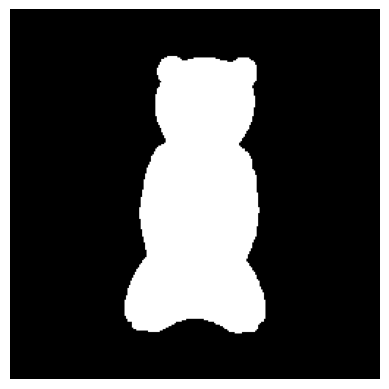

In [20]:
import cv2
def read_mask(filename):
    gray_image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    # Apply binary thresholding to convert the grayscale image to binary
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    
    mask= torch.from_numpy(binary_image).to("cuda").unsqueeze(2).repeat(1, 1, 3) / 255 #tensor is zero, black
    return mask

print(segmented_image_list[0].replace('.png','_mask.png'))

mask = read_mask(segmented_image_list[0].replace('.png','_mask.png'))

plt.imshow(mask.cpu().numpy())
plt.axis('off')  # 关闭坐标轴
plt.show()

In [21]:
targets = []
target_files = [file for file in os.listdir('target') if file.endswith('.pt')]
for target_file in target_files:
    ckpt = torch.load(f'target/{target_file}')
    targets.append(ckpt.cuda())

print(f"load {target_files} done!")


load ['K.pt', 'C.pt', 'D.pt', 'B.pt', '5.pt', '3.pt', '2.pt', 'L.pt', 'Y.pt', 'X.pt', 'A.pt', '9.pt', '4.pt', 'E.pt', '1.pt'] done!


(1, 16000, 2)


(-0.5, 0.5)

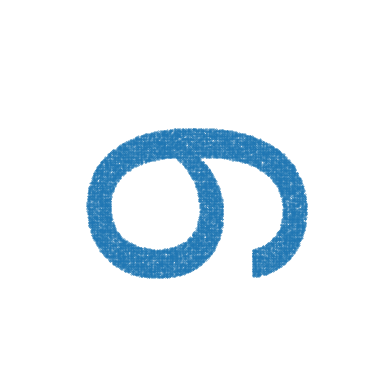

In [31]:
# import random
# point_cloud = random.choice(targets)

point_cloud = targets[11]
points = np.asarray(point_cloud.cpu())
print(points.shape)

# 展示点云数据
plt.figure()
plt.scatter(points[:,:, 0], points[:,:, 1], s=0.1)  # 在xy平面上展示点云，颜色为蓝色，大小为1
plt.axis('off')  # 关闭坐标轴
plt.gca().set_aspect('equal', adjustable='box')  # 设置画布长宽比例为1:1
# 设置切割区域为正方形，宽度以y轴为准

ymin=-0.5
ymax = 0.5
center_x = 0
plt.ylim(ymin, ymax)  # 设置y轴范围
plt.xlim(center_x - (ymax - ymin) / 2, center_x + (ymax - ymin) / 2)


In [32]:

for batch in dataloader:
    batch = todevice(batch)
    
    # image_features = model.get_image_feature(batch)  
    # print(image_features.shape) # torch.Size([1, 773, 252, 252])
    with torch.autocast('cuda',enabled=False):
    # eps=0.1, step_size=0.015, iters=40
        adv_batch = pgd_batch(batch, 
                              target=point_cloud,
                    model=model.get_point_cloud, 
                    clamp_min=0, 
                    clamp_max=1,
                    eps=4/255, # The higher, the less imperceptible the attack is 
                    step_size=0.005, # Set smaller than eps
                    iters=200, # The higher, the stronger your attack will be
                    mask = mask,
                   )




[Running attack]: Loss 0.00353 | step size: 7.475e-05: 100%|██████████| 200/200 [00:52<00:00,  3.79it/s]


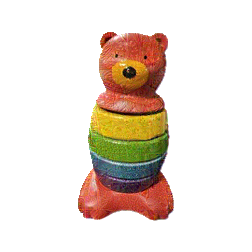

In [33]:
# adv_image = to_pil(adv_batch['rgb_cond']).convert("RGB")
# adv_batch['rgb_cond'][:, :, mask == 0] = 1.0  # 设置为白色

adv_image = to_pil(adv_batch['rgb_cond'].squeeze(0).permute(0, 3, 1, 2).squeeze(0).cpu()).convert("RGB")
# adv_image.save('output.png')

adv_image

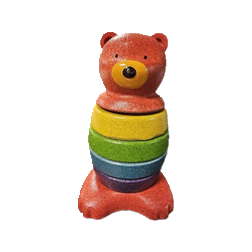

In [34]:
for batch in dataloader:
    batch = todevice(batch)

batch['rgb_cond'].data[:, :, mask == 0] = 1.0  # 设置为白色

image = to_pil(batch['rgb_cond'].squeeze(0).permute(0, 3, 1, 2).squeeze(0).cpu()).convert("RGB")
image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<built-in method type of Tensor object at 0x7f92da2270e0>


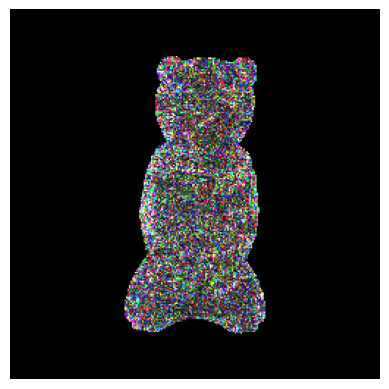

In [35]:
# Convert images to numpy arrays


    
image_np = np.array(image) / 255. 
adv_image_np = np.array(adv_image) / 255.

# Compute the difference (residual) between the two images
residual = np.abs(image_np - adv_image_np)


print(mask.type)

# Multiply the residual by 10
residual_10x = residual * 10

# Create a PIL Image from the 10x residual array
residual_10x_image = Image.fromarray((residual_10x).astype(np.uint8), 'RGB')


plt.imshow(residual_10x, cmap='hot')  # 'hot' 是一个色彩映射方案的名称
# plt.colorbar()  # 显示色条
plt.axis('off')  # 关闭坐标轴显示
plt.show()


In [36]:
#
model(adv_batch)

model.save_img_sequences(
    "video",
    "(\d+)\.png",
    save_format="mp4",
    fps=30,
    delete=True,
)
print("save to :", args.out)

save to : outputs


In [37]:
# model(batch)
# model.save_img_sequences(
#     "video",
#     "(\d+)\.png",
#     save_format="mp4",
#     fps=30,
#     delete=True,
# )

outputs/3dgs/bear_rgba.ply


(-0.5, 0.5)

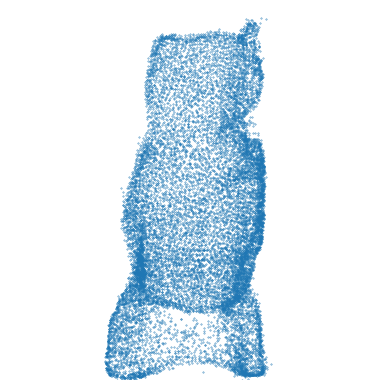

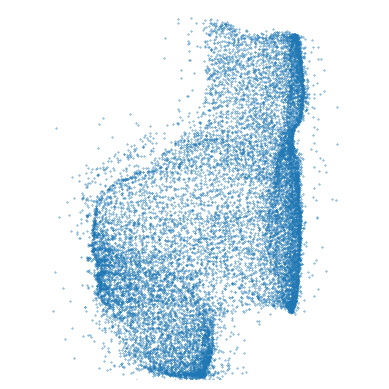

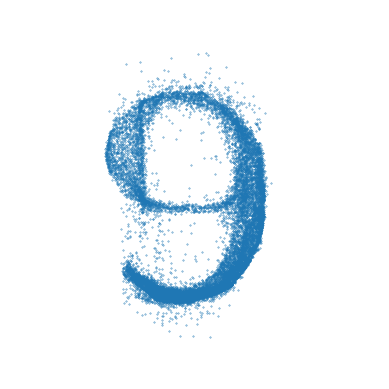

In [38]:
import trimesh
import matplotlib.pyplot as plt
import numpy as np

name = os.path.basename(segmented_image_list[0].replace('png','ply'))

ply_file = f'outputs/3dgs/{name}'

print(ply_file)

# 读取.ply文件
mesh = trimesh.load_mesh(ply_file)
points = np.asarray(mesh.vertices)


# 展示点云数据
plt.figure()
plt.scatter(points[:, 1], points[:, 2], s=0.1)  # 在xy平面上展示点云，颜色为蓝色，大小为1
plt.axis('off')  # 关闭坐标轴
plt.gca().set_aspect('equal', adjustable='box')  # 设置画布长宽比例为1:1
# 设置切割区域为正方形，宽度以y轴为准

ymin=-0.5
ymax = 0.5
center_x = 0
plt.ylim(ymin, ymax)  # 设置y轴范围
plt.xlim(center_x - (ymax - ymin) / 2, center_x + (ymax - ymin) / 2)

# 展示点云数据
plt.figure()
plt.scatter(points[:, 0], points[:, 2], s=0.1)  # 在xy平面上展示点云，颜色为蓝色，大小为1
plt.axis('off')  # 关闭坐标轴
plt.gca().set_aspect('equal', adjustable='box')  # 设置画布长宽比例为1:1
# 设置切割区域为正方形，宽度以y轴为准

ymin=-0.5
ymax = 0.5
center_x = 0
plt.ylim(ymin, ymax)  # 设置y轴范围
plt.xlim(center_x - (ymax - ymin) / 2, center_x + (ymax - ymin) / 2)



# 展示点云数据
plt.figure()
plt.scatter(points[:, 1], -points[:, 0], s=0.1)  # 在xy平面上展示点云，颜色为蓝色，大小为1
plt.axis('off')  # 关闭坐标轴
plt.gca().set_aspect('equal', adjustable='box')  # 设置画布长宽比例为1:1


ymin=-0.5
ymax = 0.5
center_x = 0
plt.ylim(ymin, ymax)  # 设置y轴范围
plt.xlim(center_x - (ymax - ymin) / 2, center_x + (ymax - ymin) / 2)



outputs/video/bear_rgba.mp4
4


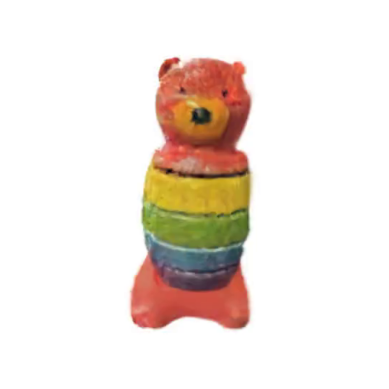

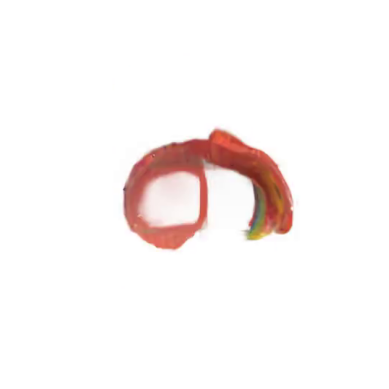

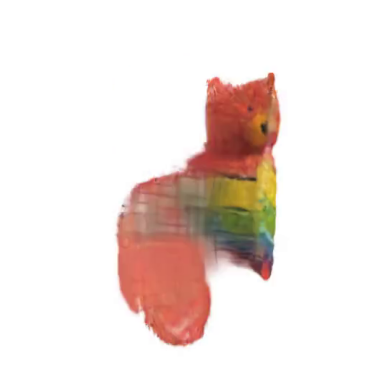

In [39]:
name = os.path.basename(segmented_image_list[0].replace('png','mp4'))

mp4_file = f'outputs/video/{name}'

print(mp4_file)
cap = cv2.VideoCapture(mp4_file)

# 获取视频的总帧数和帧率
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

# 计算每三帧的间隔
interval = total_frames // 4
print(total_frames)
# 初始化帧计数器
frame_count = 0

# 初始化图像列表
frames = []

# 逐帧读取视频
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    # 保存每三帧
    if frame_count % interval == 0:
        frames.append(frame)

    frame_count += 1
    
cap.release()
# 保存三张图片
name = name.replace('.mp4','')

for i in range(0,4):
#     cv2.imwrite(f'./outputs/3dgs/{name}_frame_{i}.jpg', frames[i])
    if i!=1:
        plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
